In [1]:
from google.colab import files

# Prompt user to upload file(s)
uploaded = files.upload()

# Access the uploaded file
for filename in uploaded.keys():
    print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')


Saving merged_dataset.csv to merged_dataset.csv
User uploaded file "merged_dataset.csv" with length 2444581 bytes


Dataset loaded with 12900 tweets.
Distribution of labels:
label
Reliable          6719
Misinformation    6181
Name: count, dtype: int64
Preprocessing tweets...
Creating TF-IDF vectors...
TF-IDF matrix shape: (12900, 1000)
Creating similarity network with threshold 0.2...
Processed 1000/12900 nodes, 216191 edges created so far
Processed 2000/12900 nodes, 415433 edges created so far
Processed 3000/12900 nodes, 598236 edges created so far
Processed 4000/12900 nodes, 764133 edges created so far
Processed 5000/12900 nodes, 912954 edges created so far
Processed 6000/12900 nodes, 1039263 edges created so far
Processed 7000/12900 nodes, 1141638 edges created so far
Processed 8000/12900 nodes, 1228074 edges created so far
Processed 9000/12900 nodes, 1303827 edges created so far
Processed 10000/12900 nodes, 1363775 edges created so far
Processed 11000/12900 nodes, 1398779 edges created so far
Processed 12000/12900 nodes, 1424120 edges created so far
Network created with 12900 nodes and 1432134 e

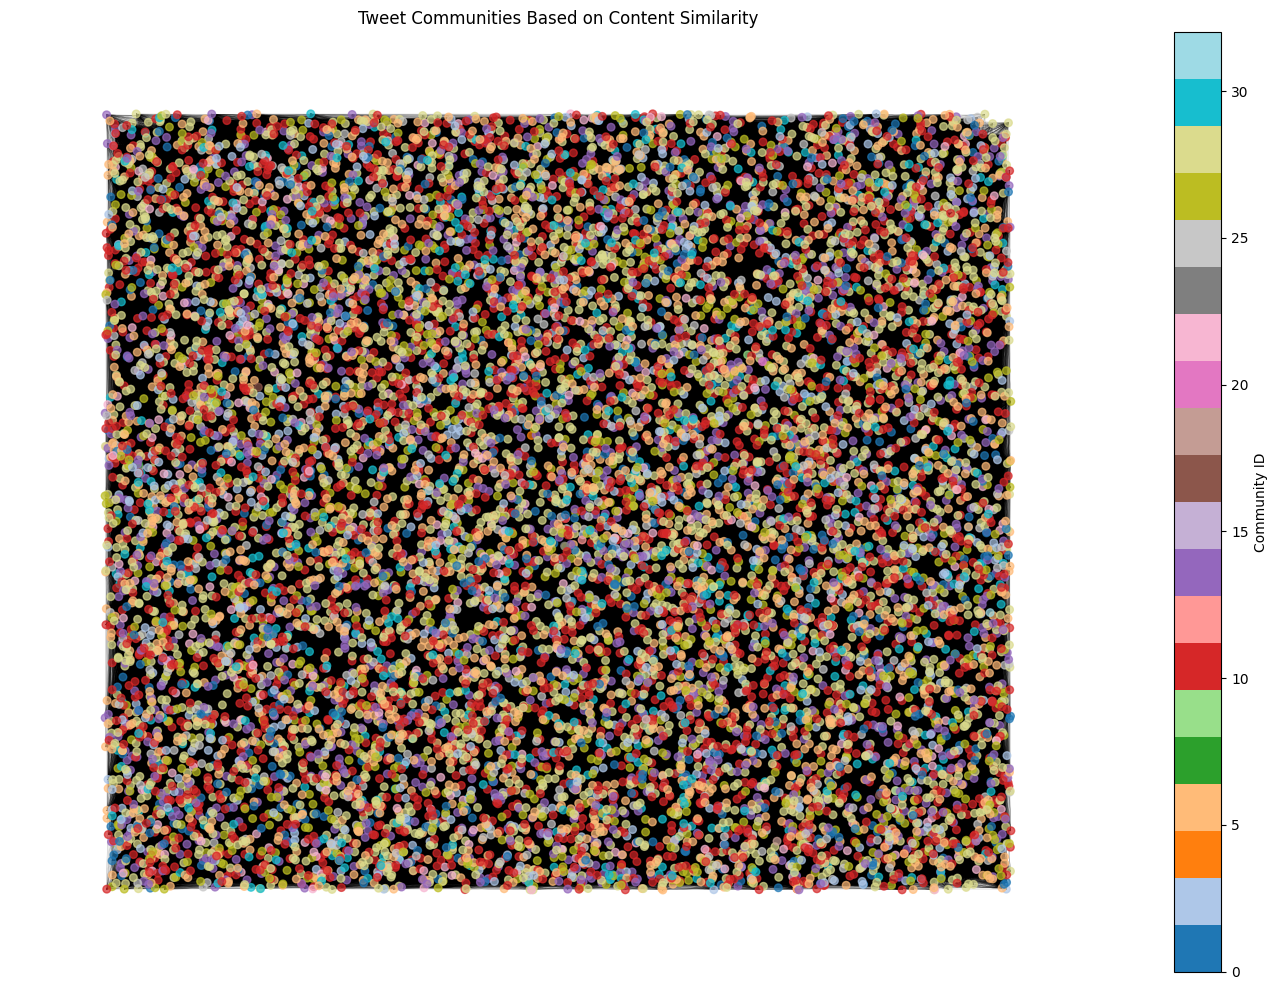

<Figure size 1200x600 with 0 Axes>

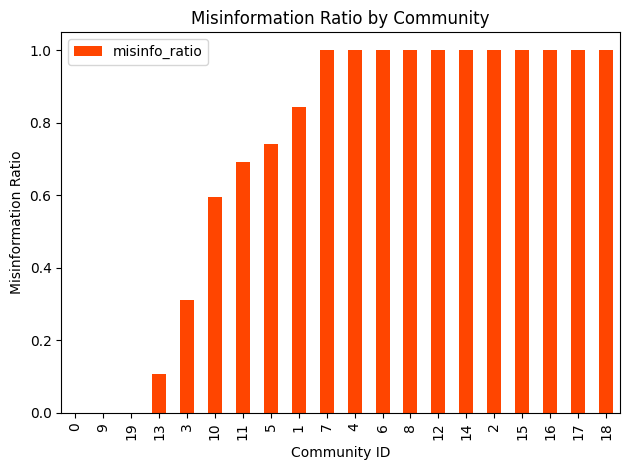

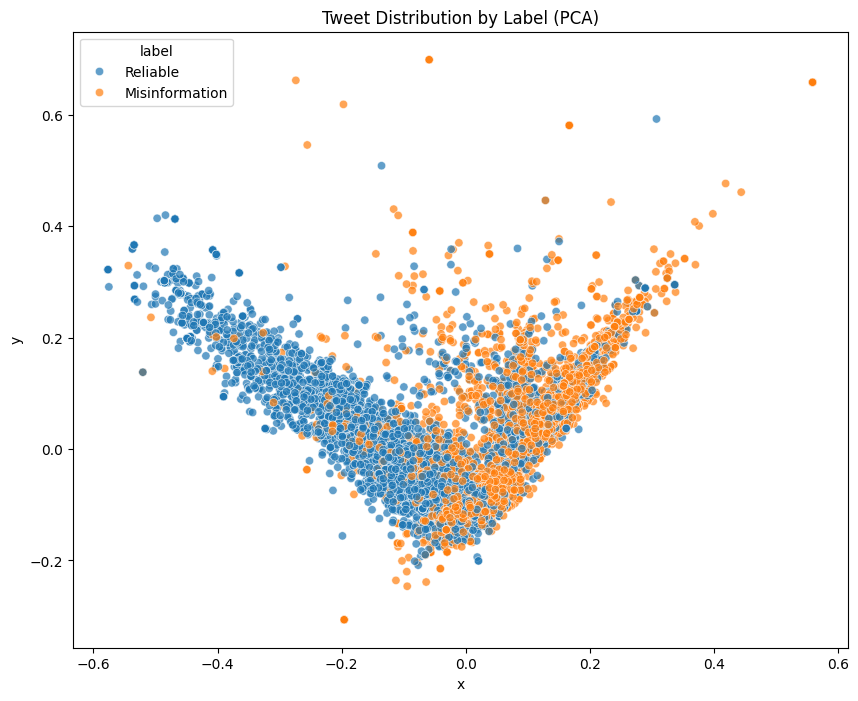

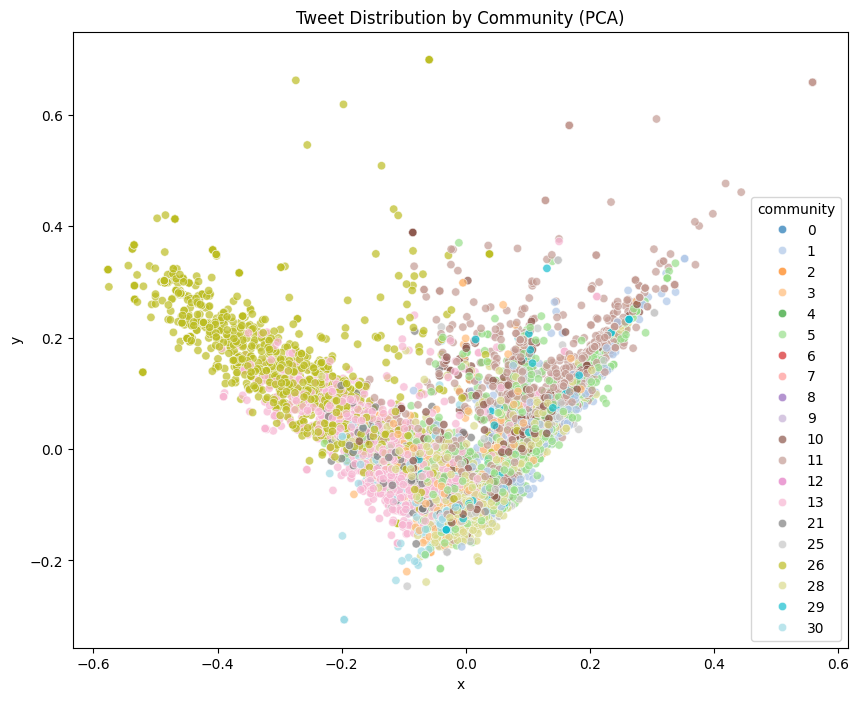

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import re
from collections import Counter
import community as community_louvain
import warnings
warnings.filterwarnings('ignore')

def load_data(file_path):
    """Load the tweet dataset"""
    df = pd.read_csv(file_path)
    print(f"Dataset loaded with {len(df)} tweets.")
    print(f"Distribution of labels:\n{df['label'].value_counts()}")
    return df

# Text preprocessing without NLTK tokenization
def preprocess_text(text):
    """Clean and preprocess tweet text"""
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        # Remove user mentions
        text = re.sub(r'@\w+', '', text)
        # Remove non-alphanumeric characters except hashtags
        text = re.sub(r'[^a-zA-Z0-9#\s]', '', text)
        # Extract hashtags separately
        hashtags = re.findall(r'#\w+', text)
        # Remove hashtag symbol for text analysis
        text = re.sub(r'#', '', text)

        # Simple word tokenization (split by whitespace)
        tokens = text.split()

        # Remove short words (stopwords are handled by TfidfVectorizer)
        tokens = [word for word in tokens if len(word) > 2]

        # Rejoin
        clean_text = ' '.join(tokens)
        return clean_text, hashtags
    else:
        return "", []


def extract_features(df):
    """Extract text features and prepare for community detection"""
   
    print("Preprocessing tweets...")
    processed_results = [preprocess_text(content) for content in df['content']]
    df['clean_text'] = [result[0] for result in processed_results]
    df['hashtags'] = [result[1] for result in processed_results]

    print("Creating TF-IDF vectors...")
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['clean_text'])
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

    feature_names = vectorizer.get_feature_names_out()

    return tfidf_matrix, feature_names, df

def create_similarity_network(tfidf_matrix, threshold=0.2):
    """Create a network based on tweet content similarity"""
    print(f"Creating similarity network with threshold {threshold}...")
    cosine_sim = cosine_similarity(tfidf_matrix)

    G = nx.Graph()

    for i in range(len(cosine_sim)):
        G.add_node(i)

    edge_count = 0
    for i in range(len(cosine_sim)):
        for j in range(i+1, len(cosine_sim)):
            if cosine_sim[i, j] > threshold:
                G.add_edge(i, j, weight=cosine_sim[i, j])
                edge_count += 1

        if i % 1000 == 0 and i > 0:
            print(f"Processed {i}/{len(cosine_sim)} nodes, {edge_count} edges created so far")

    print(f"Network created with {len(G.nodes())} nodes and {len(G.edges())} edges.")
    return G, cosine_sim

def detect_communities(G):
    """Detect communities in the tweet similarity network"""
    print("Detecting communities...")
    partition = community_louvain.best_partition(G)

    communities = pd.Series(partition)

    print(f"Detected {len(set(partition.values()))} communities.")
    community_sizes = pd.Series(partition.values()).value_counts()
    print(f"Largest community size: {community_sizes.max()}")
    print(f"Smallest community size: {community_sizes.min()}")
    return communities

def analyze_communities(df, communities, feature_names, tfidf_matrix):
    """Analyze the detected communities"""
    print("Analyzing communities...")
    df['community'] = communities.values

    community_label_counts = df.groupby('community')['label'].value_counts().unstack().fillna(0)

    if 'Misinformation' in community_label_counts.columns and 'Reliable' in community_label_counts.columns:
        community_label_counts['misinfo_ratio'] = community_label_counts['Misinformation'] / (
            community_label_counts['Misinformation'] + community_label_counts['Reliable'])
    elif 'misinformation' in community_label_counts.columns and 'reliable' in community_label_counts.columns:
        community_label_counts['misinfo_ratio'] = community_label_counts['misinformation'] / (
            community_label_counts['misinformation'] + community_label_counts['reliable'])

    community_terms = {}
    for community_id in df['community'].unique():
        community_indices = df[df['community'] == community_id].index

        community_tfidf = tfidf_matrix[community_indices]

        community_tfidf_sum = np.sum(community_tfidf.toarray(), axis=0)

        top_indices = community_tfidf_sum.argsort()[-10:][::-1]
        top_terms = [(feature_names[i], community_tfidf_sum[i]) for i in top_indices]
        community_terms[community_id] = top_terms

    community_hashtags = {}
    for community_id in df['community'].unique():
        community_tweets = df[df['community'] == community_id]
        all_hashtags = [tag for tags_list in community_tweets['hashtags'] for tag in tags_list if tags_list]
        hashtag_counts = Counter(all_hashtags).most_common(10)
        community_hashtags[community_id] = hashtag_counts

    return community_label_counts, community_terms, community_hashtags

def visualize_communities(G, communities, community_label_counts):
    """Visualize the community network"""
    print("Visualizing communities...")

    fig, ax = plt.subplots(figsize=(14, 10))

    node_colors = [communities[node] for node in G.nodes()]

    
    if len(G.nodes()) > 1000:
        pos = nx.random_layout(G) 
    else:
        pos = nx.spring_layout(G, k=0.05, iterations=50)

   
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30,
                          alpha=0.7, cmap=plt.cm.tab20, ax=ax)
    nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.5, ax=ax)

    ax.set_title("Tweet Communities Based on Content Similarity")
    ax.axis('off')

    community_values = list(communities)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.tab20,
                              norm=plt.Normalize(vmin=min(community_values),
                                               vmax=max(community_values)))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label="Community ID")

    plt.tight_layout()
    plt.savefig('covid_tweet_communities.png', dpi=300)

    if 'misinfo_ratio' in community_label_counts.columns:
        plt.figure(figsize=(12, 6))
        top_communities = community_label_counts.index.to_series().value_counts().nlargest(20).index
        comm_subset = community_label_counts.loc[top_communities].sort_values('misinfo_ratio')

        comm_subset.plot(
            kind='bar', y='misinfo_ratio',
            color='orangered',
            title='Misinformation Ratio by Community'
        )
        plt.ylabel('Misinformation Ratio')
        plt.xlabel('Community ID')
        plt.tight_layout()
        plt.savefig('misinfo_ratio_by_community.png', dpi=300)

    return pos

def visualize_tweets_2d(tfidf_matrix, df):
    """Create a 2D visualization of tweets using PCA"""
    print("Creating 2D visualization...")
    pca = PCA(n_components=2)
    tweet_pca = pca.fit_transform(tfidf_matrix.toarray())

    viz_df = pd.DataFrame({
        'x': tweet_pca[:, 0],
        'y': tweet_pca[:, 1],
        'label': df['label'],
        'community': df['community']
    })

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=viz_df, x='x', y='y', hue='label', alpha=0.7)
    plt.title('Tweet Distribution by Label (PCA)')
    plt.savefig('tweets_by_label_pca.png', dpi=300)

    plt.figure(figsize=(10, 8))
    community_subset = viz_df['community'].value_counts().nlargest(20).index
    viz_df_subset = viz_df[viz_df['community'].isin(community_subset)]

    sns.scatterplot(data=viz_df_subset, x='x', y='y', hue='community', palette='tab20', alpha=0.7)
    plt.title('Tweet Distribution by Community (PCA)')
    plt.savefig('tweets_by_community_pca.png', dpi=300)

def main(file_path, similarity_threshold=0.2, sample_size=None):
    """Main function to run the community detection pipeline"""
    
    df = load_data(file_path)

    if sample_size is not None and sample_size < len(df):
        print(f"Sampling {sample_size} tweets for analysis...")
        df = df.sample(sample_size, random_state=42)

    tfidf_matrix, feature_names, df = extract_features(df)

    G, cosine_sim = create_similarity_network(tfidf_matrix, similarity_threshold)

    communities = detect_communities(G)

    community_label_counts, community_terms, community_hashtags = analyze_communities(
        df, communities, feature_names, tfidf_matrix)

    try:
        pos = visualize_communities(G, communities, community_label_counts)
    except Exception as e:
        print(f"Network visualization error: {e}")
        print("Skipping network visualization but continuing with analysis...")
        pos = None

    try:
        visualize_tweets_2d(tfidf_matrix, df)
    except Exception as e:
        print(f"PCA visualization error: {e}")
        print("Skipping PCA visualization but continuing with analysis...")

    print("\n=== Community Analysis ===")
    print("\nMisinformation ratio by community:")
    if 'misinfo_ratio' in community_label_counts.columns:
        print(community_label_counts[['misinfo_ratio']].sort_values('misinfo_ratio', ascending=False).head(10))
    else:
        print(community_label_counts)

   
    community_sizes = df['community'].value_counts()
    print("\nTop communities by size:")
    print(community_sizes.head(10))

    top_communities = community_sizes.nlargest(10).index

    print("\nTop terms by major communities:")
    for community_id in sorted(top_communities):
        terms = community_terms.get(community_id, [])
        if terms:
            print(f"\nCommunity {community_id} (size: {community_sizes[community_id]}):")
            for term, score in terms[:10]:  
                print(f"  {term}: {score:.3f}")

    print("\nTop hashtags by major communities:")
    for community_id in sorted(top_communities):
        hashtags = community_hashtags.get(community_id, [])
        if hashtags:
            print(f"\nCommunity {community_id} (size: {community_sizes[community_id]}):")
            for hashtag, count in hashtags[:10]:  
                print(f"  {hashtag}: {count}")

    return df, G, communities, community_label_counts, community_terms, community_hashtags


def export_network_data(G, df, output_prefix="covid_network"):
    """Export network data for visualization in tools like Gephi"""
    print("Exporting network data for external visualization...")


    node_data = []
    for node in G.nodes():
        node_data.append({
            'id': node,
            'label': df.iloc[node]['label'],
            'community': df.iloc[node]['community']
        })

    node_df = pd.DataFrame(node_data)
    node_df.to_csv(f"{output_prefix}_nodes.csv", index=False)


    edge_data = []
    for u, v, data in G.edges(data=True):
        edge_data.append({
            'source': u,
            'target': v,
            'weight': data.get('weight', 1.0)
        })

    edge_df = pd.DataFrame(edge_data)
    edge_df.to_csv(f"{output_prefix}_edges.csv", index=False)

    print(f"Network data exported to {output_prefix}_nodes.csv and {output_prefix}_edges.csv")
    print("These files can be imported into Gephi or other network visualization tools.")

    return node_df, edge_df


if __name__ == "__main__":
  
    file_path = "/content/merged_dataset.csv" 

    sample_size = None  # Set to a number (e.g., 5000) to sample or None to use all data
    similarity_threshold = 0.2  # Increase to 0.3 or higher if network is too dense


    df, G, communities, community_label_counts, community_terms, community_hashtags = main(
        file_path, similarity_threshold=similarity_threshold, sample_size=sample_size)

    
    export_network_data(G, df)


    df.to_csv("covid_tweets_with_communities.csv", index=False)

    print("\nAnalysis complete! Results saved to CSV and PNG files.")